# Data visualtisation Notebook

## Objectives

*   Answer business requirement 1: \n",
         * The client is interested to have a more efficient way to visually differentiate a healthy and powdery mildew infected leaves.

## Inputs

*   inputs/cherry_dataset/cherry-leaves/train
*   inputs/cherry_dataset/cherry-leaves/validation
*   inputs/cherry_dataset/cherry-leaves/test

## outputs

*   Image shape embedding file
*   Mean and variabillity of images per label plot
*   Plot to provide the contrast beetween healthy and powdery mildew leaves.
*   Generate code that awnsers the requirement 1 and can be used to build an image montage with streamlit dashboard.

## Additional Comments | Insights | Conclusions

# Set Data Directory

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspace/cherry')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/cherry'

## Set Input Directories

* Set train, validation, test paths.

In [6]:
my_data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set Label Names

In [8]:
#labels
labels = os.listdir(train_path)
print('Label for the images are, labels')

Label for the images are, labels


# Data Visualisation Of Image Data

## Image shape

* compute average image size on train set

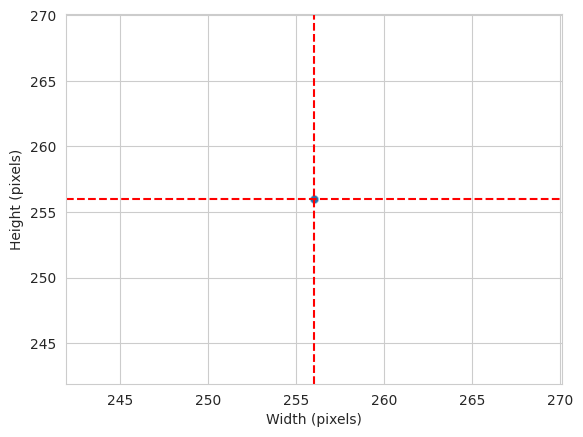

Width average: 256 
Height average: 256


In [9]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # img height
        dim2.append(d2)  # img width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

### Reduce image size for training to 45x45

In [10]:
image_shape = (45, 45 ,3)
image_shape

(45, 45, 3)

* Save the image shape embed

In [20]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

# Average And Variablility Of Images Per Label

## Function To Load Images in An Array (tensor)

In [11]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: limit, because it may take too long time
      if counter < n_images_per_label:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

2025-01-27 07:00:54.936270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Image Shape And Labels In Array

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                          n_images_per_label = 30)
print(X.shape, y.shape)

(60, 45, 45, 3) (60,)


## Plot And Save Mean And Variability Of Images Per Label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
   The pseudo code for the function is:
  * Loop in all labels
  * Subset an array for given label
  * Calculate mean and standard deviation
  * Create a figure displaying mean and variability of images
  * Save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label healthy ====
Image Shape: (45, 45, 3)
==== Label powdery_mildew ====
Image Shape: (45, 45, 3)


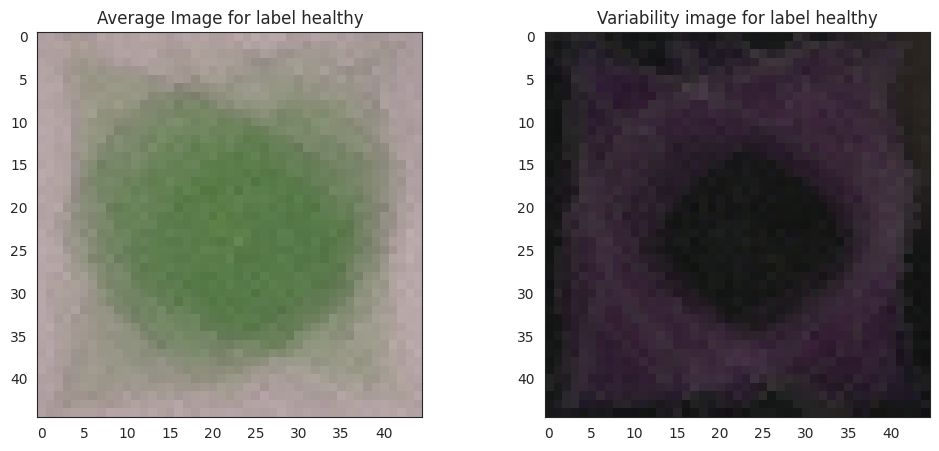

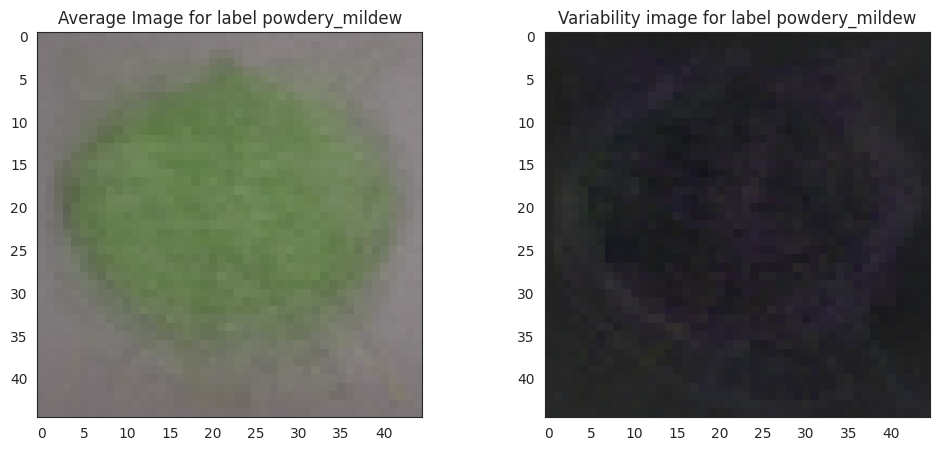

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

# Differences Between Healthy and Powedered Mildew Leaves Images

In [15]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    return X[boolean_mask]

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False, file_path="."):
    """
    Calculates and plots the difference between the average images of two labels.
    
    Parameters:
    - X: np.array, image data.
    - y: np.array, image labels.
    - label_1: int, first label to compare.
    - label_2: int, second label to compare.
    - figsize: tuple, size of the plotted figure.
    - save_image: bool, whether to save the image.
    - file_path: str, where to save the image if save_image is True.
    """
    sns.set_style("white")

    if label_1 not in np.unique(y) or label_2 not in np.unique(y):
        print(f"Labels {label_1} or {label_2} are not in {np.unique(y)}")
        return

    # Calculate means
    label1_avg = np.mean(subset_image_label(X, y, label_1), axis=0)
    label2_avg = np.mean(subset_image_label(X, y, label_2), axis=0)

    # Calculate difference
    difference_mean = label1_avg - label2_avg
    
    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference: Avg {label_1} & {label_2}')

    plt.tight_layout()
    
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


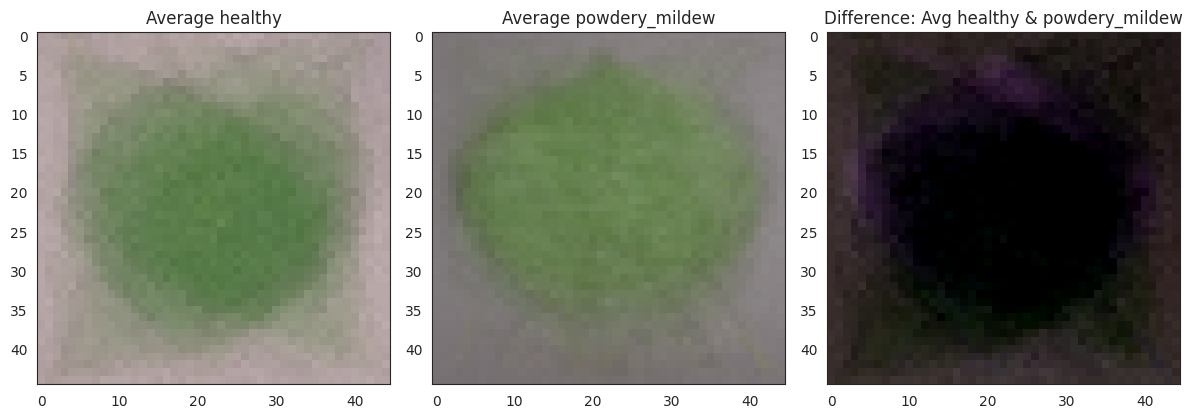

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

## Image Montage

In [18]:
import itertools
import random
sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Displays a montage of images from the specified directory.

    Parameters:
    - dir_path: str, path to the directory containing images.
    - label_to_display: str, label of the images to be displayed.
    - nrows: int, number of rows in the montage.
    - ncols: int, number of columns in the montage.
    - figsize: tuple, size of the plotted figure.
    """
    
    labels = os.listdir(dir_path)

    # Check if the label exists in the directory
    if label_to_display in labels:

        # List all images in the specified label directory
        images_list = os.listdir(f"{dir_path}/{label_to_display}")
        
        # Ensure montage space is not greater than the number of images
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage.\n"
                f"There are {len(images_list)} images in your subset.\n"
                f"You requested a montage with {nrows * ncols} spaces."
            )
            return

        # Create a list of axes indices based on nrows and ncols
        list_rows = range(nrows)
        list_cols = range(ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # Create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for idx in range(nrows * ncols):
            img_path = f"{dir_path}/{label_to_display}/{img_idx[idx]}"
            img = imread(img_path)
            img_shape = img.shape
            ax = axes[plot_idx[idx][0], plot_idx[idx][1]]
            ax.imshow(img)
            ax.set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


* Run Montage In All Labels

healthy


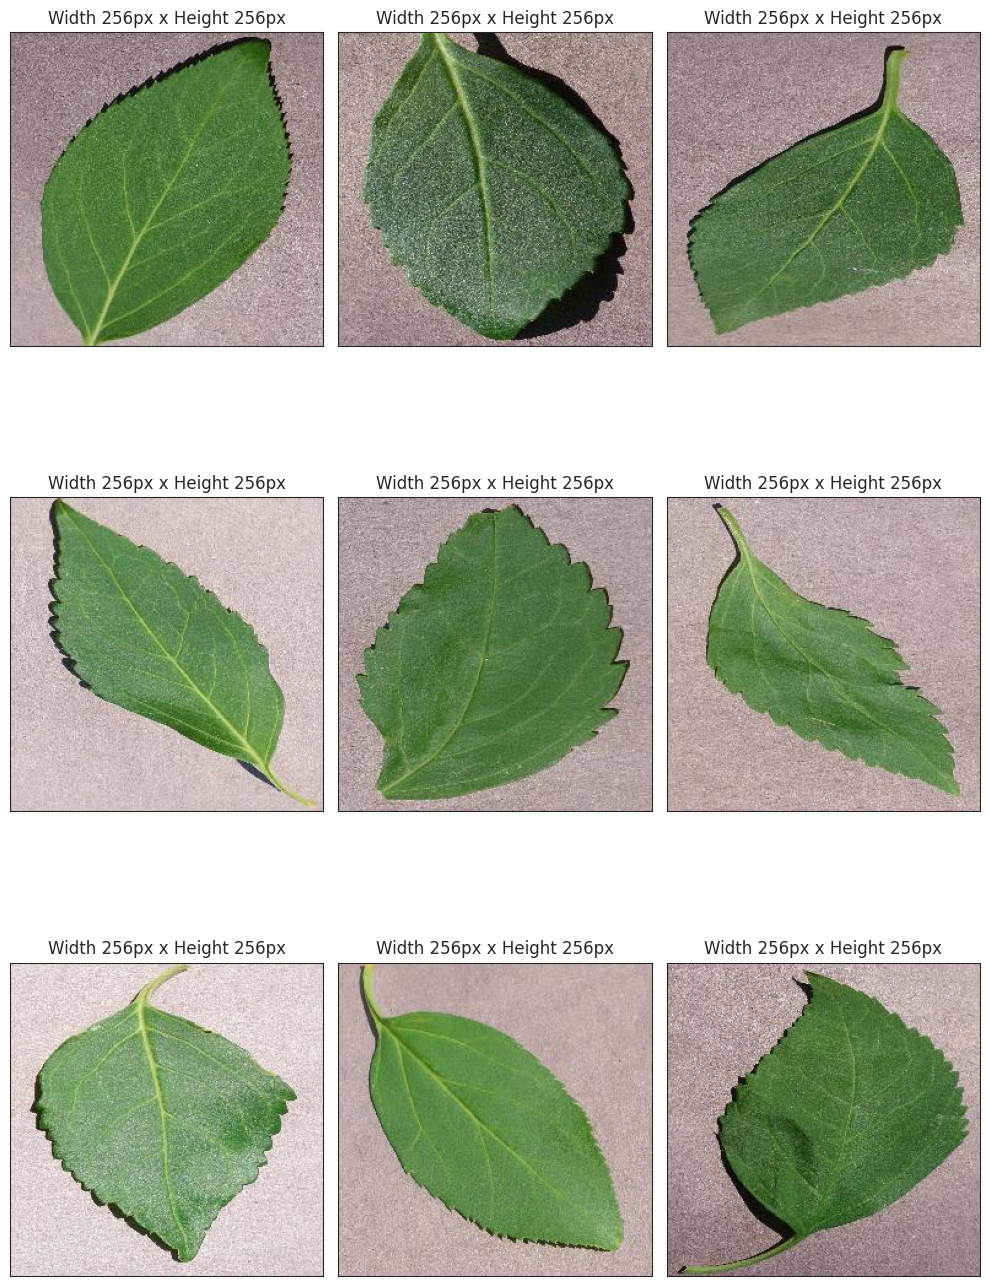



powdery_mildew


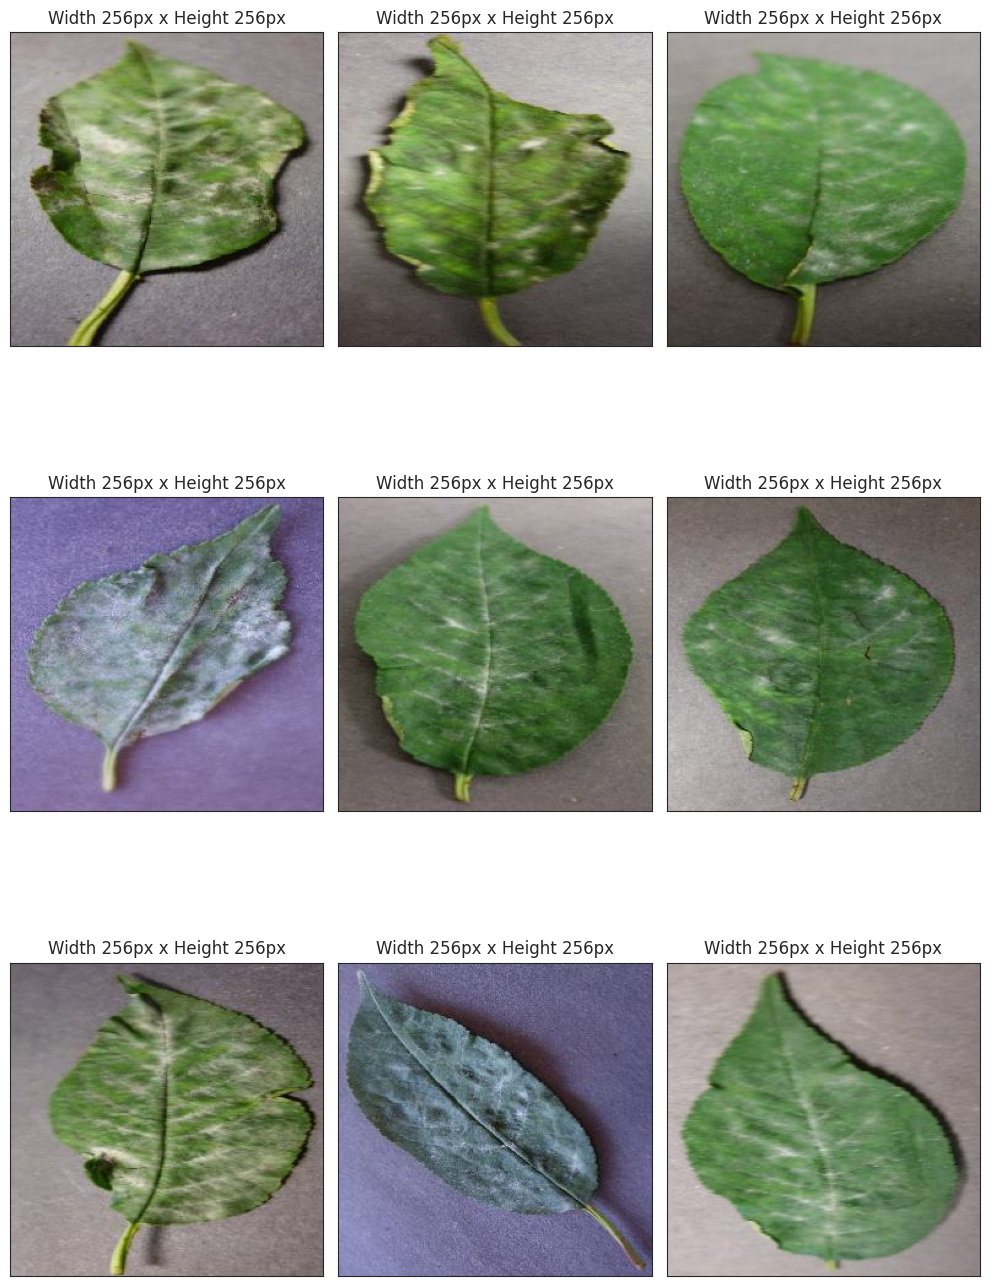

In [19]:
for label in labels:
  print(label)
  image_montage(dir_path= train_path,
                label_to_display= label,
                nrows=3, ncols=3,
                figsize=(10,15)
                )
  print("\n")